# 2025-10-06 SVD Geometry

* Solving least squares problems

* Geometry of the SVD

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Here's our Vandermonde matrix again
function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

vander (generic function with 2 methods)

## Least squares and the normal equations

A least squares problem takes the form: given an $m \times n$ matrix $A$ ($m \geq n$), find $x$ such that

$$ \left\lvert \left\lvert A x - b \right\rvert \right\rvert $$

is minimized.
If $A$ is square and full rank, then this minimizer will satisfy $A x - b = 0$, but that is not the case in general because $b$ may not be in the range of $A$.
The residual $A x - b$ must be orthogonal to the range of $A$.

* Is this the same as saying $A^T \left( A x - b \right) = 0$?

* If $Q R = A$, is it the same as $Q^T \left( A x - b \right) = 0$?

$Q Q^T$ is an orthogonal projector onto the range of $Q$.
If $Q R = A$, then 

$$ Q Q^T \left( A x - b \right) = Q Q^T \left( Q R x - b \right) = Q \left( Q^T Q \right) R x - Q Q^T b = Q R x - Q Q^T b = A x - Q Q^T b $$

So if $b$ is in the range of $A$, we can solve $A x = b$.
If not, we need only *orthogonally* project $b$ into the range of $A$.

### Solution by $QR$ (Householder)

Solve $R x = Q^T b$.

* $QR$ factorization costs $2 m n^2 - \frac{2}{3} n^3$ operations and is done once per matrix $A$

* Computing $Q^T b$ costs $4 \left( m - n \right) n + 2 n^2 = 4 m n - 2 n^2$ (using elementary reflectors, which are stable and lower storage than naive storage of $Q$)

* Solving with $R$ costs $n^2$ operations, making total cost per $b$ thus $4 m n - n^2$

### Solution by Cholesky

The mathematically equivalent form $A^T A x = A^T b$ are called the **normal equations**.
The solution process involves factoring the symmetric and positive definite $n \times n$ matrix $A^T A$.

* Computing $A^T A$ costs $m n^2$ FLOPs (exploit symmetry)

* Factoring $A^T A = R^T R$ costs $\frac{1}{3} n^3$ FLOPs, for a total of $m n^2 + \frac{1}{3} n^3$

* Computing $A^T b$ costs $2 m n$

* Solving with $R^T$ costs $n^2$

* Solving with $R$ costs $n^2$ for a total cost per $b$ of $2 m n + 2 n^2$

The product $A^T A$ is ill-conditioned, $\kappa \left( A^T A \right) = \kappa \left( A \right)^2$, which can reduce the accuracy of a least squares solution.

### Solution by Singular Value Decomposition

Next, we will consider the factorization

$$ U \Sigma V^T = A $$

where $U$ and $V$ have orthonormal columns and $\Sigma$ is diagonal with non-negative entries.
The entries of $\Sigma$ are called **singular values** and this decomposition is called the [**singular value decomposition**](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD).
It may remind you of an eigenvalue decomposition $X \Lambda X^{-1} = A$, but

* the SVD exists for all matrices (including non-square and deficient matrices)

* $U$ and $V$ have orthogonal columns (while $X$ can be arbitrarily ill-conditioned)

In fact, if a matrix is symmetric and positive definite (all positive eigenvalues), then $U = V$ and $\Sigma = \Lambda$.

For this algorithm

* Computing an SVD requires a somewhat complicated iterative algorithm, but a crude estimate of the cost is $2 m n^2 + 11 n^3$ (Similar to $QR$ when $m \gg n$ but much more expensive for square matrices)

* Computing $U^T b$ costs $2 m n$

* Solving with the diagonal matrix $\Sigma$ costs $n$

* Applying $V$ costs $2 n^2$ for a total cost per $b$ of $2 m n + 2 n^2$

## Geometry of the SVD

In [2]:
default(aspect_ratio=:equal)

# Let's use the peanut blob again
function peanut()
    theta = LinRange(0, 2*pi, 50)
    r = 1 .+ .4*sin.(3*theta) + .6*sin.(2*theta)
    r' .* [cos.(theta) sin.(theta)]'
end

# and a perfect circle
function circle()
    theta = LinRange(0, 2*pi, 50)
    [cos.(theta) sin.(theta)]'
end

function Aplot(A)
    "Plot a transformation from X to Y"
    X = peanut()
    Y = A * X
    p = scatter(X[1,:], X[2,:], label="in")
    scatter!(p, Y[1,:], Y[2,:], label="out")
    X = circle()
    Y = A * X
    q = scatter(X[1,:], X[2,:], label="in")
    scatter!(q, Y[1,:], Y[2,:], label="out")
    plot(p, q, layout=2)
end

Aplot (generic function with 1 method)

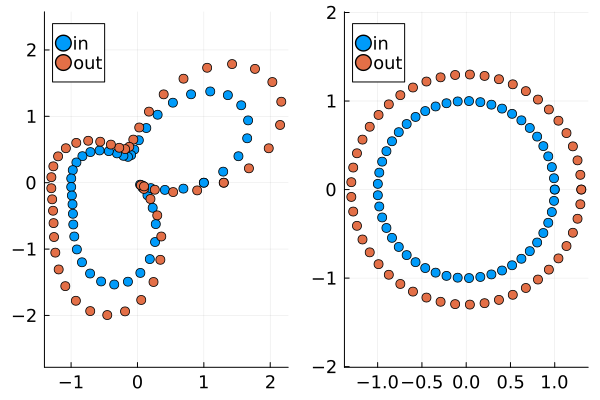

In [3]:
Aplot(1.3*I)

### Diagonal matrices

The simplest transformation may be a scalar multiple of the identity matrix.

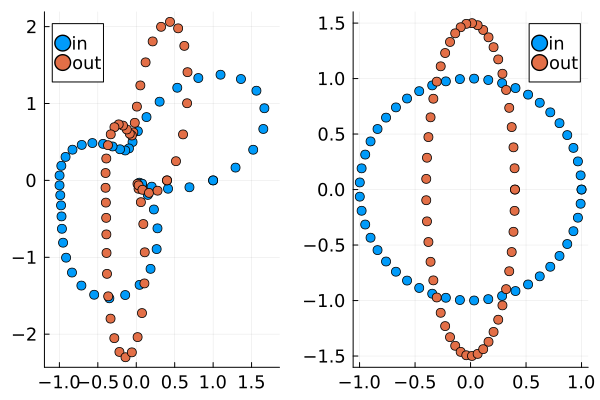

In [4]:
Aplot([.4 0; 0 1.5])

The circles become an **ellipse** that is aligned with the coordinate axis but stretches differently in each direction based upon the entries on the diagonal.

### Given Rotation (orthogonal matrix example)

We can rotate the input using a $2 \times 2$ matrix, parameterized by $\theta$.
Its transpose rotates in the opposite direction.

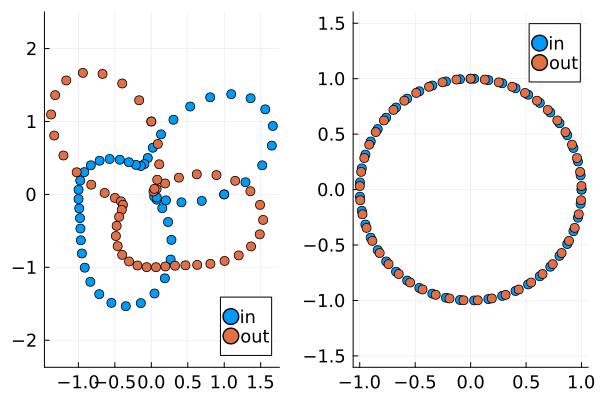

In [4]:
function givens(θ)
    s = sin(θ)
    c = cos(θ)
    [c -s; s c]
end

G = givens(π/2)
Aplot(G)

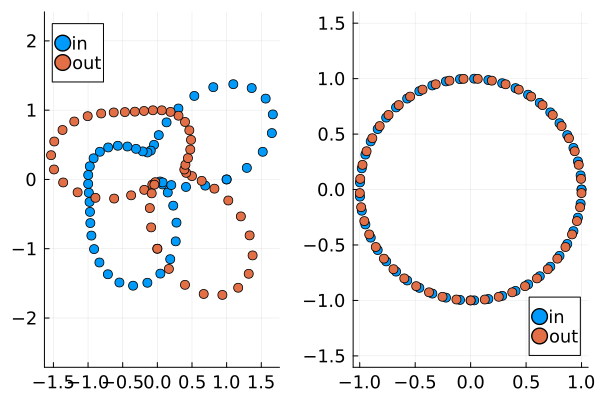

In [5]:
Aplot(G')

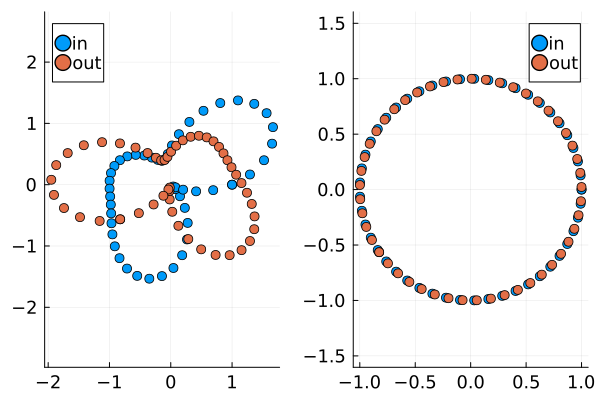

In [6]:
function reflect(θ)
    v = [cos(θ), sin(θ)]
    I - 2 * v * v'
end

Aplot(reflect(0.3))

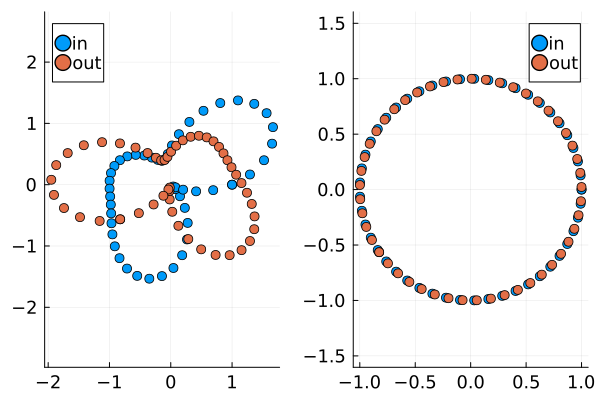

In [7]:
function reflect(θ)
    v = [cos(θ), sin(θ)]
    I - 2 * v * v'
end

Aplot(reflect(0.3))

## Singular Value Decomposition

The SVD is $A = U \Sigma V^T$ where $U$ and $V$ have orthonormal columns and $\Sigma$ is diagonal with non-negative entries.
It exists for any matrix (non-square, singular, etc.).

If we think of orthogonal matrices as reflections/rotations, this says that any matrix can be represented as reflect/rotate, diagonally scale, and reflect/rotate again.

Let's try a random symmetric matrix.

det(A) = -2.397012048118953


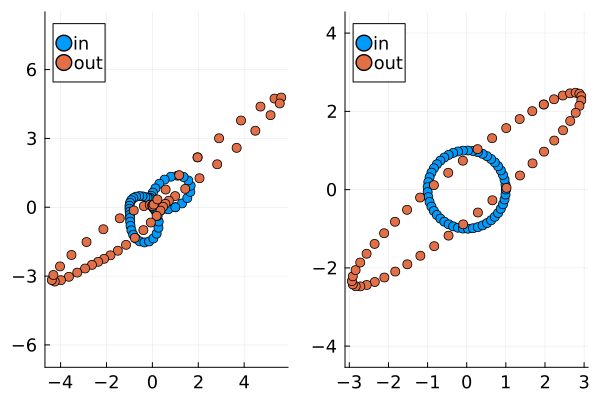

In [8]:
A = randn(2, 2)
A += A' # make symmetric
@show det(A) # Positive means orientation is preserved
Aplot(A)

In [15]:
U, S, V = svd(A)
# Should be zero
@show norm(U * diagm(S) * V' - A);

norm(U * diagm(S) * V' - A) = 4.965068306494546e-16


### Parts of the SVD

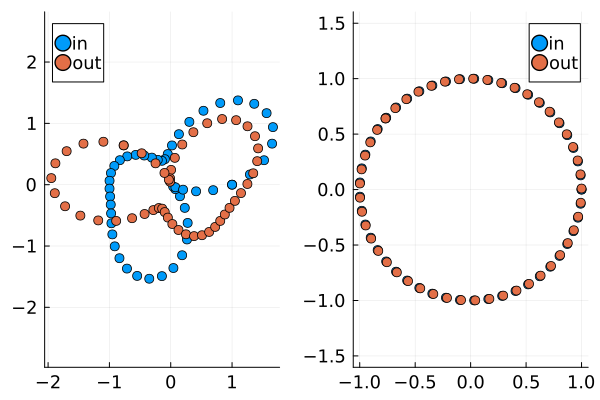

In [16]:
# Rotate/reflect in preparation for scaling
Aplot(V')

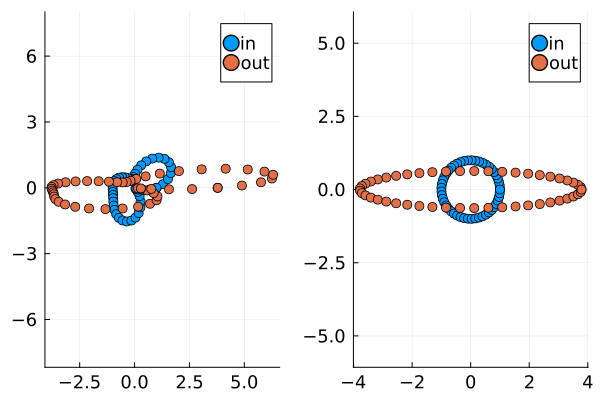

In [17]:
# Scale along axes
Aplot(diagm(S))

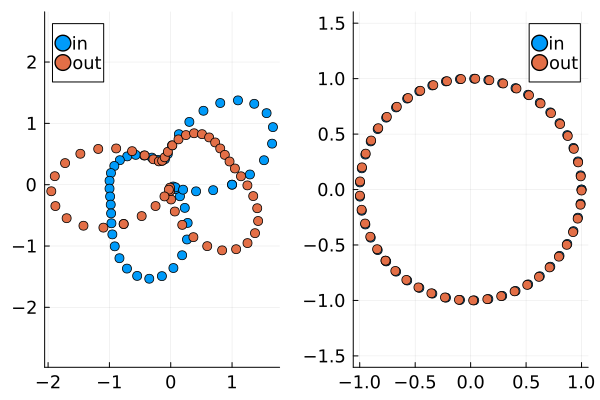

In [18]:
# Rotate/reflect back
Aplot(U)

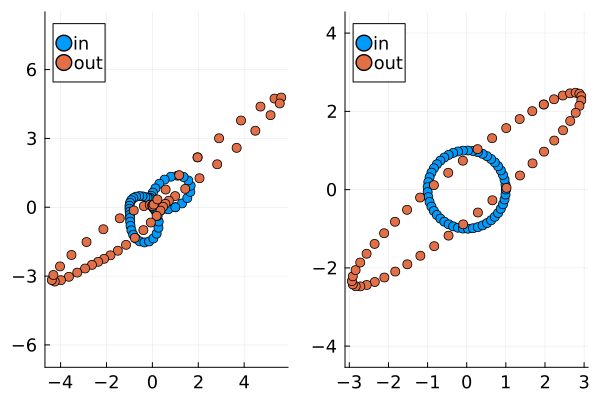

In [19]:
# And all together
Aplot(U * diagm(S) * V')

### Observations

* The circle always maps to an ellipse

* The $U$ and $V$ factors may reflect even when $\text{det} \left( A \right) > 0$

### Exploration

What does $U$ and $V$ mean if $A$ is non-square?

## Ill-conditioning

What makes a matrix ill-conditioned?

In [20]:
A = [10 5; .9 .5]

@show cond(A)
@show svdvals(A);

cond(A) = 252.11603357237593
svdvals(A) = [11.22755613596245, 0.04453328880703381]


In [21]:
# Vandermonde is our usual ill-conditioned example
m = 100
x = LinRange(-1, 1, m)
A = vander(x, 20)

@show cond(A)
# Singular values tell us how each rotated/reflected direction scales
@show svdvals(A);

cond(A) = 7.206778416849221e6
svdvals(A) = [11.510601491136654, 8.99357244991735, 5.907360126610746, 3.6029154831946064, 1.9769729310318849, 1.0983103765769848, 0.5392322016751736, 0.2820042230178552, 0.12425066006852684, 0.061830861246220885, 0.02424292914634845, 0.011556331531623169, 0.003964435582121683, 0.0018189836735689913, 0.0005298822985646561, 0.00023487660987953318, 5.487089394445511e-5, 2.3566694052602816e-5, 3.828636525136808e-6, 1.597190981233061e-6]


The [**condition number**](https://en.wikipedia.org/wiki/Condition_number) of a matrix has the relationship with $\Sigma$ that

$$ \kappa \left( A \right) = \frac{\max_i \left( \Sigma_{i, i} \right)}{\min_i \left( \Sigma_{i, i} \right)} $$

S = [1.0988383060273739, 0.1030251687895749]
S[1] / S[end] = 10.665726821294614
cond(A) = 10.665726821294612


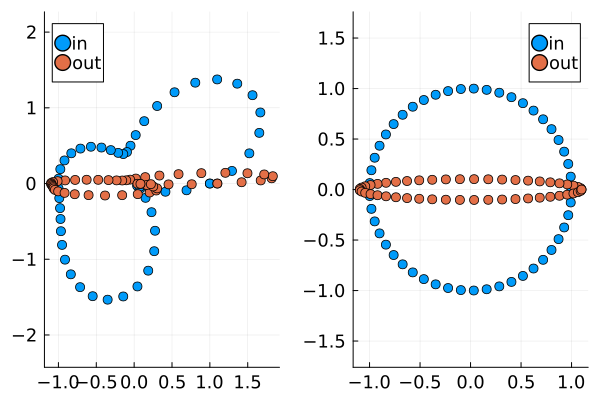

In [25]:
A = randn(2, 2)
U, S, V = svd(A)

@show S
@show S[1] / S[end]
@show cond(A)

Aplot(diagm(S))